# HW03: Distance and Topic Model

Remember that these homework work as a completion grade. **You can skip one section without losing credit.**

## Load and Pre-process Text

In [37]:
#Import the AG news dataset (same as hw01)
#Download them from here 
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv

import pandas as pd
import nltk
df = pd.read_csv('train.csv')

df.columns = ["label", "title", "lead"]
label_map = {1:"world", 2:"sport", 3:"business", 4:"sci/tech"}
def replace_label(x):
	return label_map[x]
df["label"] = df["label"].apply(replace_label) 
df["text"] = df["title"] + " " + df["lead"]
df.head()

--2023-03-16 09:32:56--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29470338 (28M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]  28.10M   162MB/s    in 0.2s    

2023-03-16 09:32:56 (162 MB/s) - ‘train.csv.1’ saved [29470338/29470338]



,label,title,lead,text
0,business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
1,business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
2,business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
3,business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."
4,business,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,"Stocks End Up, But Near Year Lows (Reuters) Re..."


In [38]:
import spacy
dfs = df.sample(200)
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import TfidfVectorizer

##TODO pre-process text as you did in HW02

dfs['preprocessed'] = dfs['text'].apply(lambda x: nlp(x))

##TODO vectorize the pre-processed text using TfidfVectorizer

vectorizer = TfidfVectorizer()
vec_text = vectorizer.fit_transform(dfs['preprocessed'].astype(str))

## Cosine Similarity and PCA

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
# Cosine_similarity = measure of similarity between two non-zero vectors.
# Used to measure similarity between two documents repr. as vectors of word frequencies or tf-idf weights
# if angle small -> vectors in similar direction -> cosine_sim close to 1 -> high similarity
# if angle close to 90 -> low similarity -> cosine_sim close to 0
# if angle close to 180 -> coseine_sim close to -1 = high dissimilarity
# NLP: find documents that are similar to given query document, or to cluster documents based on similarity

##TODO compute the cosine similarity for the first 200 snippets and for the first snippet, show the three most similar snippets and their respective cosine similarity scores

sim = cosine_similarity(vec_text)

first_snipped = sim[0]

# argsort() sorts in ascending order
# gives back index order in order to sort sim
# 1:4 to exclude the first element being the first snipped itself
top_three_ind = first_snipped.argsort()[::-1][1:4]

print('First snipped:', dfs.iloc[0]['preprocessed'])
print()


for i, index in enumerate(top_three_ind):
    print('{}: {}, similarity score = {}'.format(i+1, dfs.iloc[index]['preprocessed'], first_snipped[index]))


First snipped: US soldiers flock to laser eye clinic FORT CAMPBELL, Ky. -- Command Sergeant Major Kurt Pinero looked up from the operating table after laser eye surgery, and made out the pictures on the television screen across the room.

1: Liverpool Football Club eye Italian The Reds are in desperate need for a striker following the injuries to Djibril Cisse and Milan Baros, whilst Luis Garcias hamstring problem has hardly helped matters., similarity score = 0.087480634575598
2: US  #39;defector #39; to turn himself in Charles Robert Jenkins, a one-time US Army sergeant accused of defecting to North Korea 39 years ago, has saidy he will soon surrender to military authorities to  quot;face the charges that have been filed against me., similarity score = 0.07179255853855679
3: Hamm Wins All-Around Gymnastics Title (AP) AP - After falling onto the edge of the judges' table on the landing of his vault, Paul Hamm performed two of the most spectacular routines of his career to win the men'

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')

##TODO reduce the vectorized data using PCA

pca_vec_text = pca.fit_transform(vec_text.toarray())

##TODO compute again cosine similarity with the reduced version for the first 200 snippets

red_cos_sim = cosine_similarity(pca_vec_text)

##TODO for the first snippet, show again its three most similar snippets

first_snipped = red_cos_sim[0]
top_three_ind = first_snipped.argsort()[::-1][1:4]

print('First snipped:', dfs.iloc[0]['preprocessed'])
print()


for i, index in enumerate(top_three_ind):
    print('{}: {}, similarity score = {}'.format(i+1, dfs.iloc[index]['preprocessed'], first_snipped[index]))


First snipped: US soldiers flock to laser eye clinic FORT CAMPBELL, Ky. -- Command Sergeant Major Kurt Pinero looked up from the operating table after laser eye surgery, and made out the pictures on the television screen across the room.

1: US bishop sex abuse case dropped A child abuse case against a former US bishop is dropped, hours after he was charged., similarity score = 0.9532809859285225
2: Man Utd unveils dip in profits Manchester United says player transfers and a weaker performance on the pitch cut its full-year profits by nearly a third., similarity score = 0.9477517626667403
3: Rawlings Accuses Obasanjo of Interference Ghanaians went to the polls yesterday to elect a new President and members of Parliament with former President Jerry Rawlings accusing Nigerian President Olusegun Obasanjo of undue interference in the electoral process., similarity score = 0.9461678759759099


Compare the cosine similarity before and after PCA reduction. Did the results change? 

Yes, the results do differ. PCA reduces dimensionality of data and only preserves the most imporant relationshipds. When applying cos_sim again on the reduced space, some data may have been lost which leads to different results.

## Clustering

In [41]:
!pip install scikit-learn-extra
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

##TODO create the clusters found with k-medoids clustering nd 5 clusters

kmedoids = KMedoids(n_clusters=5, random_state=0)
kmedoids.fit(pca_vec_text)

dfs['kmedoids_cluster'] = kmedoids.labels_

##TODO create the clusters found with k-means clustering nd 5 clusters

kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(pca_vec_text)

dfs['kmeans_cluster'] = kmeans.labels_

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [42]:
dfs.head()

,label,title,lead,text,preprocessed,kmedoids_cluster,kmeans_cluster
39818,world,US soldiers flock to laser eye clinic,"FORT CAMPBELL, Ky. -- Command Sergeant Major K...",US soldiers flock to laser eye clinic FORT CAM...,"(US, soldiers, flock, to, laser, eye, clinic, ...",1,0
36169,sci/tech,Anti-Spyware Legislation Could Pass This Year ...,washingtonpost.com - Measures to curb the use ...,Anti-Spyware Legislation Could Pass This Year ...,"(Anti, -, Spyware, Legislation, Could, Pass, T...",0,2
107410,business,Oil Drops Another 5 Pct to \$43 a Barrel,LONDON (Reuters) - Oil prices crumbled anothe...,Oil Drops Another 5 Pct to \$43 a Barrel LOND...,"(Oil, Drops, Another, 5, Pct, to, \$43, a, Bar...",3,3
36149,world,British hostage pleads for life,"Facing a death threat from his Iraqi captors, ...",British hostage pleads for life Facing a death...,"(British, hostage, pleads, for, life, Facing, ...",1,0
95254,business,Google Warns of Slowing Growth,quot;Although our revenue growth rate increas...,Google Warns of Slowing Growth quot;Although ...,"(Google, Warns, of, Slowing, Growth, , quot;A...",2,2


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
<ipython-input-43-e85542ca9536>:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)


<Figure size 720x576 with 0 Axes>

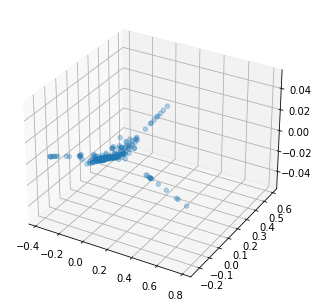

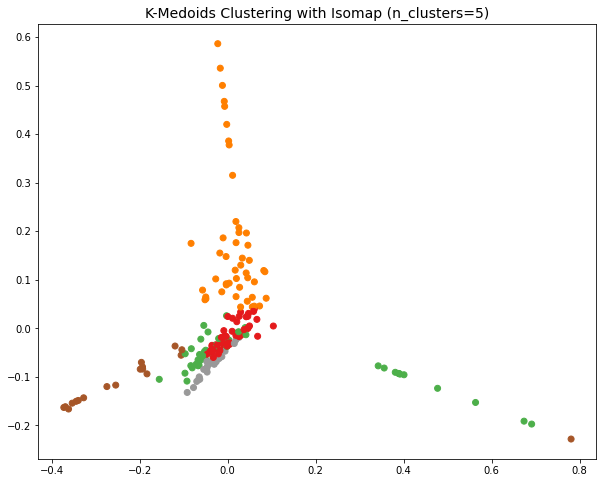

In [43]:
##TODO visualize the k-medoids clustering results through Isomap (first reduce the dimensionality to 2 using Isomap, then use scatter plot (plt.scatter()) to visualize)

from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

iso = Isomap(n_components=2)
iso_vec_text = iso.fit_transform(pca_vec_text)

plt.figure(figsize=(10,8))
Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)

# Scatter plot of k-medoids clusters using Isomap
plt.figure(figsize=(10,8))
plt.scatter(iso_vec_text[:,0],iso_vec_text[:,1], c=dfs['kmedoids_cluster'], cmap='Set1')
plt.title('K-Medoids Clustering with Isomap (n_clusters=5)', fontsize=14)
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/lib/python3.9/dist-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
<ipython-input-44-fab2099f4395>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)


<Figure size 720x576 with 0 Axes>

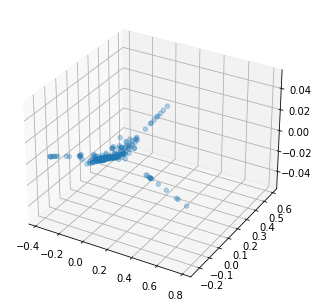

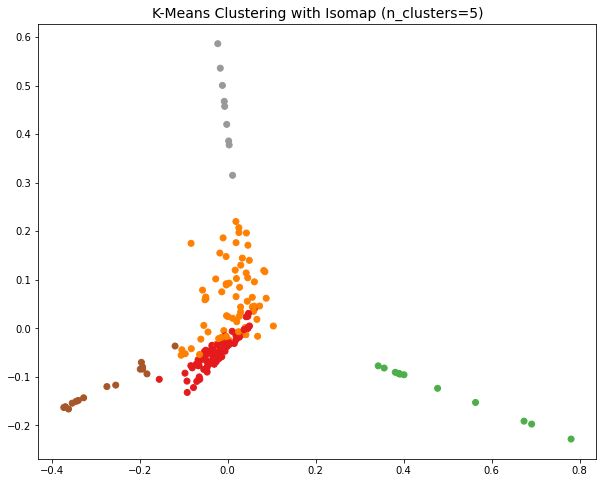

In [44]:
##TODO similarly, visualize the k-means results

iso = Isomap(n_components=2)
iso_vec_text = iso.fit_transform(pca_vec_text)

plt.figure(figsize=(10,8))
Axes3D(plt.figure()).scatter(iso_vec_text[:,0],iso_vec_text[:,1], alpha=.3)

# Scatter plot of k-medoids clusters using Isomap
plt.figure(figsize=(10,8))
plt.scatter(iso_vec_text[:,0],iso_vec_text[:,1], c=dfs['kmeans_cluster'], cmap='Set1')
plt.title('K-Means Clustering with Isomap (n_clusters=5)', fontsize=14)
plt.show()

## Topic Modeling: LDA

For this part you will need to use LDA Mallet. If you cannot have Mallet run, you can use the simple LDA algorithm 

In [45]:
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from random import shuffle

##TODO create a dictionary with the pre-processed tokenized text and filter it according to frequencies and keeping 1000 vocabularies

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

doc_clean = []

for doc in tqdm(dfs['text']):
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

shuffle(doc_clean)

dictionary = Dictionary(doc_clean)
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)

##TODO create the doc_term_matrix

doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

100%|██████████| 200/200 [00:03<00:00, 65.24it/s]


In [46]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [47]:
##TODO train a LDA Mallet model with 5, 10 and 15 topics
mallet_path = '/content/mallet-2.0.8/bin/mallet'

ldamallet_5 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=5, id2word=dictionary)
ldamallet_10 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=10, id2word=dictionary)
ldamallet_15 = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=15, id2word=dictionary)

models = [ldamallet_5, ldamallet_10, ldamallet_15]

##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

scores = []
all_topics = []

for model in models:
    coherence = CoherenceModel(model = model, texts = doc_clean, dictionary=dictionary, coherence = 'c_v')
    topics = model.show_topics(num_topics=1, num_words=10, formatted=False)[0][1]
    topics = [word for word, coherence in topics if coherence > 0.0]
    all_topics.append(topics)
    scores.append(coherence.get_coherence())

print(all_topics[scores.index(max(scores))])

/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is

[(0, '0.424*"39;s" + 0.196*"service" + 0.163*"friday" + 0.120*"monday" + 0.043*"game" + 0.033*"yesterday" + 0.022*"win" + 0.000*"price" + 0.000*"york" + 0.000*"week"'), (1, '0.262*"world" + 0.250*"year" + 0.179*"game" + 0.143*"york" + 0.131*"wednesday" + 0.024*"high" + 0.012*"monday" + 0.000*"yesterday" + 0.000*"week" + 0.000*"price"'), (2, '0.222*"oil" + 0.185*"week" + 0.148*"high" + 0.148*"price" + 0.123*"month" + 0.123*"yesterday" + 0.049*"u.s." + 0.000*"monday" + 0.000*"year" + 0.000*"tuesday"'), (3, '0.388*"win" + 0.224*"thursday" + 0.194*"company" + 0.194*"lead" + 0.000*"yesterday" + 0.000*"price" + 0.000*"week" + 0.000*"game" + 0.000*"york" + 0.000*"year"'), (4, '0.448*"reuters" + 0.194*"time" + 0.179*"tuesday" + 0.104*"u.s." + 0.075*"39;s" + 0.000*"week" + 0.000*"monday" + 0.000*"lead" + 0.000*"game" + 0.000*"york"')]
[(0, '0.419*"service" + 0.279*"high" + 0.233*"wednesday" + 0.070*"month" + 0.000*"year" + 0.000*"tuesday" + 0.000*"game" + 0.000*"yesterday" + 0.000*"monday" + 0.

In [48]:
models = [ldamallet_5, ldamallet_10, ldamallet_15]

##TODO compute the coherence score for each of these model and print the topics from the model with highest coherence score. Then find the opitimal number of topics using the coherence score.

scores = []
all_topics = []

for model in models:
    coherence = CoherenceModel(model = model, texts = doc_clean, dictionary=dictionary, coherence = 'c_v')
    topics = model.show_topics(num_topics=1, num_words=10, formatted=False)[0][1]
    topics = [word for word, coherence in topics if coherence > 0.0]
    all_topics.append(topics)
    scores.append(coherence.get_coherence())

print(all_topics[scores.index(max(scores))])

0
[['reuters', 'time', 'tuesday', 'u.s.', '39;s'], ['game', 'yesterday', 'month', 'wednesday'], ['oil', 'reuters', 'price', 'wednesday']]
['reuters', 'time', 'tuesday', 'u.s.', '39;s']


In [51]:
print(scores)

[0.46533876357206577, 0.4558899750412255, 0.4538109273980511]


In [53]:
opt_score = []
for num_topics in range(2, 20):
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=doc_clean, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    opt_score.append((num_topics, coherence.get_coherence()))

print(opt_score)

/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is

[(2, 0.42490286380932624), (3, 0.43957131102874974), (4, 0.46384959776361845), (5, 0.45023716442201095), (6, 0.4644132168933623), (7, 0.45332698026969626), (8, 0.46472474369748934), (9, 0.445066120380914), (10, 0.45447135324897375), (11, 0.45270111804154944), (12, 0.4538983968576907), (13, 0.4561728373512422), (14, 0.4494866426333184), (15, 0.45135530661328993), (16, 0.45106684561888005), (17, 0.45204785149407284), (18, 0.4552637011731319), (19, 0.4534048303442832)]


In [54]:
print(opt_score)

scores = [coherence for num_topics, coherence in opt_score]
opt_topics = opt_score[scores.index(max(scores))][0]
print(opt_topics)

[(2, 0.42490286380932624), (3, 0.43957131102874974), (4, 0.46384959776361845), (5, 0.45023716442201095), (6, 0.4644132168933623), (7, 0.45332698026969626), (8, 0.46472474369748934), (9, 0.445066120380914), (10, 0.45447135324897375), (11, 0.45270111804154944), (12, 0.4538983968576907), (13, 0.4561728373512422), (14, 0.4494866426333184), (15, 0.45135530661328993), (16, 0.45106684561888005), (17, 0.45204785149407284), (18, 0.4552637011731319), (19, 0.4534048303442832)]
8


In [55]:
# !pip install pyLDAvis
import pyLDAvis.gensim
from gensim.models import wrappers
##TODO using LDAvis visualize the topics using the optimal number of topics

lda_model = wrappers.LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=opt_topics, id2word=dictionary)

# create visualization
vis_data = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis_data)

/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.9/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


AttributeError: ignored